# Process CycleAtlanta Users
- Cross reference trips_0.pkl with user.csv
- Identify potential duplicate users through email and other information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

In [2]:
config = json.load((Path.cwd() / 'config.json').open('rb'))
export_fp = Path(config['project_directory']) / 'CycleAtlanta'
if export_fp.exists() == False:
    export_fp.mkdir()

In [3]:
project_dir = Path(config['project_directory']) / "CycleAtlanta"
user_data_definitions = json.load(open(Path.cwd()/'user_data_definition.json'))
cycleatlanta_data_filepath = Path(config['cycleatlanta'])

In [4]:
user = pd.read_csv(cycleatlanta_data_filepath/'user.csv')
user_col = ['userid','created_date','device','email','age','gender','income','ethnicity','homeZip','schoolZip','workZip','cycling_freq','rider_history','rider_type','app_version']
user.columns = user_col
user.drop(columns=['device','app_version'], inplace=True)

#change datatypes
user['created_date'] = pd.to_datetime(user['created_date'])

int_columns = ['userid','homeZip','schoolZip','workZip']
for int_column in int_columns:
    user[int_column] = pd.to_numeric(user[int_column],errors='coerce')
    user.loc[user[int_column].isna(),int_column] = -1
    user[int_column] = user[int_column].astype(int)

intial_unique_users = user['userid'].nunique()
print(intial_unique_users,'users identified')

1724 users identified


## Fill in data with data dict dictionary and mark null values

In [5]:
for key, item in user_data_definitions.items():
    if key in user.columns:
        user[key] = user[key].astype(float).astype(int).astype(str).map(item)

#format email
user.loc[user['email']=='-1','email'] = 'NULL'

## Add the number of trips to the user dataframe

In [6]:
# with (project_dir/'coords_0.pkl').open('rb') as fh:
#     coords_dict = pickle.load(fh)

with (project_dir/'trips_0.pkl').open('rb') as fh:
    trips = pickle.load(fh)

In [7]:
trips['userid'] = trips['userid'].astype(int)
trips_by_user = trips.groupby('userid').size().reset_index(name='count')

before_merge = user.shape[0]
user = user.merge(trips_by_user,on='userid')
print(before_merge-user.shape[0],'users were not in the trips database')
print((~trips['userid'].isin(user['userid'])).sum(),'trips had users that were not in the users database')
trips_to_remove = trips.loc[~trips['userid'].isin(user['userid']),'tripid'].tolist()

trips = trips[trips['userid'].isin(user['userid'])]

665 users were not in the trips database
21 trips had users that were not in the users database


Remove these trips from the coords database

In [8]:
with (project_dir/'coords_0.pkl').open('rb') as fh:
    coords_dict = pickle.load(fh)
for tripid in trips_to_remove:
    coords_dict.pop(tripid)
with (project_dir/'coords_1.pkl').open('wb') as fh:
    pickle.dump(coords_dict,fh)
del coords_dict

In [9]:
# #only keep user if 2 trips or more? (leave out for now)
# under_5 = user.shape[0]
# user = user[user['count']>=5]
# print(under_5-user.shape[0],'users after only including users with 5 or more trips')

## Trip count by user

In [10]:
user[['userid','email','count']].sort_values('count',ascending=False)

,userid,email,count
623,931,kmyerschamberlain@gmail.com,3946
818,1275,josephmcintyre@mac.com,954
891,1369,stephenwillard@bellsouth.net,651
82,108,syl.turner@gmail.com,326
142,177,NULL,312
...,...,...,...
1,15,NULL,1
97,125,NULL,1
845,1308,lackofintellect@gmail.com,1
530,750,NULL,1


In [11]:
user.sort_values('count',ascending=False).head(20)

,userid,created_date,email,age,gender,income,ethnicity,homeZip,schoolZip,workZip,cycling_freq,rider_history,rider_type,count
623,931,2013-06-18 21:17:57,kmyerschamberlain@gmail.com,NULL,NULL,NULL,NULL,30030,-1,30308,NULL,NULL,NULL,3946
818,1275,2013-10-14 04:53:26,josephmcintyre@mac.com,25-34,Male,"$60,000 to $74,999",White,30317,-1,30318,Daily,Since childhood,"Comfortable, but cautious",954
891,1369,2013-11-25 04:32:46,stephenwillard@bellsouth.net,45-54,Male,"$100,000 or greater",White,30030,-1,30306,Several times per week,Since childhood,Strong & fearless,651
82,108,2012-10-16 15:50:09,syl.turner@gmail.com,25-34,Male,"$75,000 to $99,999",White,30030,-1,30308,NULL,Several years,"Comfortable, but cautious",326
142,177,2012-10-19 14:48:23,NULL,NULL,NULL,NULL,White,-1,-1,-1,Daily,Since childhood,Enthused & confident,312
1007,1654,2015-07-06 04:59:46,kyler.powell@gmail.com,25-34,Male,"$100,000 or greater",White,30317,-1,30303,Several times per week,Several years,Enthused & confident,291
57,78,2012-10-16 03:28:50,stephenwillard@bellsouth.net,NULL,NULL,NULL,White,30030,-1,30306,Several times per week,Since childhood,Enthused & confident,286
629,945,2013-06-22 07:02:19,kyler.powell@Gmail.com,25-34,Male,"$100,000 or greater",White,30317,-1,30313,Several times per week,Several years,Enthused & confident,186
543,770,2013-05-16 07:27:23,chris@maddope.com,NULL,Male,NULL,NULL,-1,-1,-1,NULL,Several years,Enthused & confident,185
986,1619,2015-04-08 05:08:24,fiterfly@gmail.com,25-34,Male,"$100,000 or greater",Asian,30324,-1,-1,Several times per week,Since childhood,"Comfortable, but cautious",184


## How many users have completely null fields?

In [12]:
null_columns = ['age','gender','income','ethnicity','cycling_freq','rider_history','rider_type']
neg1_columns = ['homeZip','schoolZip','workZip']
((user[null_columns]=='NULL').all(axis=1) & (user[neg1_columns]==-1).all(axis=1)).sum()

186

## Plot trips over time

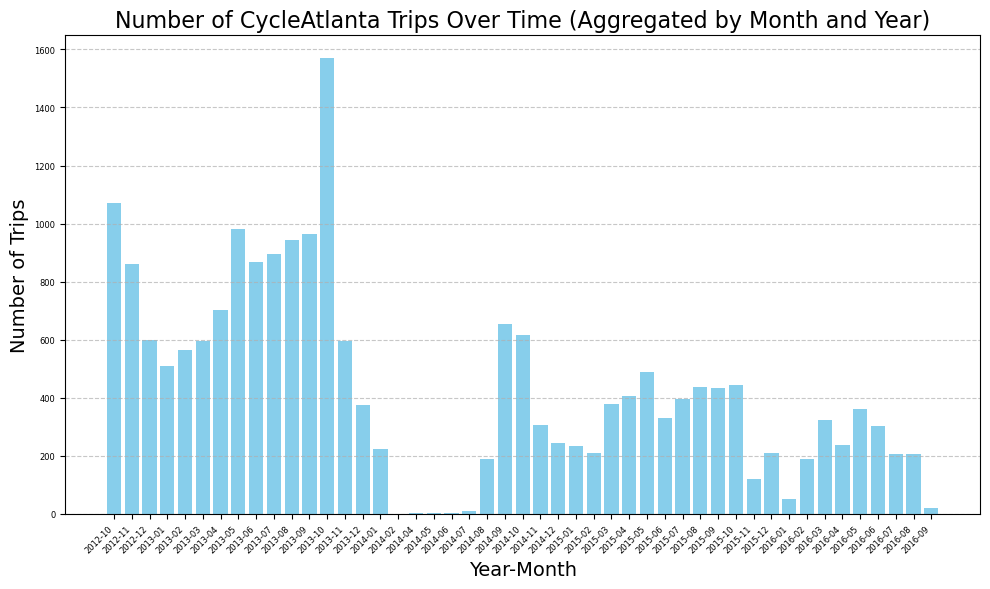

In [13]:
to_plot = trips.copy()

to_plot['year_month'] = to_plot['initial_start_time'].dt.to_period('M')
monthly_counts = to_plot.groupby('year_month').size().reset_index(name='count')
monthly_counts
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_counts['year_month'].astype(str),monthly_counts['count'],color='skyblue')
ax.set_title('Number of CycleAtlanta Trips Over Time (Aggregated by Month and Year)', fontsize=16)
ax.set_xlabel('Year-Month', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=6)  # Set font size of tick labels
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45,ha='right')
# Show the plot
plt.tight_layout()
plt.show()

In [14]:
#have a version with duplicted users that we can test in redundant trips
with (project_dir/'users_0.pkl').open('wb') as fh:
    pickle.dump(user,fh)
#TODO implement this to get a correct size change
# with (project_dir/'trips_1.pkl').open('wb') as fh:
#     pickle.dump(user,fh)

## Deal with duplicate users (identified by email)

In [15]:
dup_users_cond = user['email'].duplicated(keep=False) & (user['email'] != 'NULL')
dup_users = user[dup_users_cond]
user = user[~dup_users_cond]
print((~dup_users_cond).sum(),'potential duplicate users')

902 potential duplicate users


In [16]:
user_remap = {}
def duplicate_function(x):
    '''
    Function for processing the duplicate users
    '''
    
    if x.name == 'count':
        return x.sum()

    #just take the first start date
    if x.name == 'created_date':
        return x.min()

    unique_values = x.unique().tolist()

    if x.name == 'userid':
        if len(unique_values) > 1:
            user_remap.update({i:unique_values[0] for i in unique_values if i != unique_values[0]})
        #     return unique_values[0]
        # else:
        #     return unique_values

    #count nans (nan != nan so do that to avoid type issues)
    count_nans = np.array([val != val for val in unique_values])

    # all nans
    if count_nans.all():
        return np.nan

    # at least one nan
    if count_nans.any():
        unique_values = [val for val in unique_values if val == val]

    # check lenth
    if len(unique_values) == 1:
        return unique_values[0]
    else:
        return unique_values

In [17]:
dup_users = dup_users.groupby('email').agg(lambda x: duplicate_function(x)).reset_index('email')

In [18]:
user = pd.concat([user,dup_users],ignore_index=True)
print("Started with",intial_unique_users,"users, now at",user.shape[0],"users")

Started with 1724 users, now at 972 users


Just retain the first user id (create a dict and remap in the trip dataframe)

In [19]:
user_remap

with (project_dir/'remapped_users.pkl').open('wb') as fh:
    pickle.dump(user_remap,fh)

In [20]:
remapped_userid = trips['userid'].map(user_remap)
trips['remapped_userid'] = trips['userid']
trips.loc[~remapped_userid.isna(),'remapped_userid'] = remapped_userid

In [21]:
#new pickles
with (project_dir/'trips_1.pkl').open('wb') as fh:
    pickle.dump(trips,fh)

with (project_dir/'users_1.pkl').open('wb') as fh:
    pickle.dump(user,fh)

## Examine Duplicate Users
Select a random user that was flagged a duplicate user and inspect to see if it was valid

In [22]:
import geopandas as gpd

duplicate_users = user[user['userid'].apply(lambda x: isinstance(x,list))]
random_duplicate = duplicate_users['userid'].sample(1).item()

duplicate_users_trips = trips[trips['userid'].isin(random_duplicate)].copy()

origins = duplicate_users_trips[['tripid','userid','remapped_userid','start_X','start_Y']].copy()
origins.columns = ['tripid','userid','remapped_userid','X','Y']
origins['type'] = 'origin'
dests = duplicate_users_trips[['tripid','userid','remapped_userid','end_X','end_Y']].copy()
dests.columns = ['tripid','userid','remapped_userid','X','Y']
dests['type'] = 'destination'

duplicate_users_points = pd.concat([origins,dests],ignore_index=True)
geometry = gpd.points_from_xy(duplicate_users_points['X'],duplicate_users_points['Y'])
duplicate_users_points = gpd.GeoDataFrame(duplicate_users_points,geometry=geometry,crs='epsg:2240')
duplicate_users_points.explore('userid',categorical=True,marker_kwds={'radius':5,'draggable':True},style_kwds={'fillOpacity':1})
#duplicate_users_points.to_file(Path.home()/'Downloads/test.gpkg',layer='dup_check')